In [ ]:
!pip install pyspark

In [2]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession

spark=SparkSession.builder.appName('FordGoBike').getOrCreate()
spark




In [3]:
#path="/workspaces/develhope-Data5-Team3/Data/week_3"
path='G:\My Drive\Develhope\develhope-Data5-Team3\Data\week_3'
df=spark.read.csv(path,header=True, inferSchema=True)

In [5]:
df.columns

['start_time',
 'start_am_pm',
 'end_time',
 'end_am_pm',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_distance',
 'Diff_in_seconds',
 'Diff_in_minutes',
 'Trip_cost',
 'age',
 'age_group']

##TASK_1 - calculate the total cost for all customers and all subscribers

In [4]:
df.groupBy('user_type').agg({'Trip_cost': 'sum'}).show()

+----------+------------------+
| user_type|    sum(Trip_cost)|
+----------+------------------+
|Subscriber|1700972.6358333328|
|  Customer| 438035.9841666664|
+----------+------------------+



##TASK_2 - Analyze how often bikes are being rented ( morning - afternoon - evening) and and find the density for each hour of the day

In [5]:
#https://www.britannica.com/dictionary/eb/qa/parts-of-the-day-early-morning-late-morning-etc

df=df.withColumn('time_of_the_day', F.when(((F.hour('start_time')>=5) & (F.hour('start_time')<12)),'Morning')\
                      .otherwise(F.when((F.hour('start_time')>=12)&(F.hour('start_time')<18),'Afternoon')\
                      .otherwise(F.when((F.hour('start_time')>=18)&(F.hour('start_time')<21),'Evening')\
                                 .otherwise('Night'))))


In [6]:
df_time_of_day=df.groupBy('time_of_the_day').agg(F.count('start_time').alias('total_rents'))

In [7]:
df_time_of_day.show()

+---------------+-----------+
|time_of_the_day|total_rents|
+---------------+-----------+
|        Evening|     109824|
|        Morning|      91341|
|      Afternoon|     141648|
|          Night|      99012|
+---------------+-----------+



In [8]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [9]:
pd=df_time_of_day.toPandas()

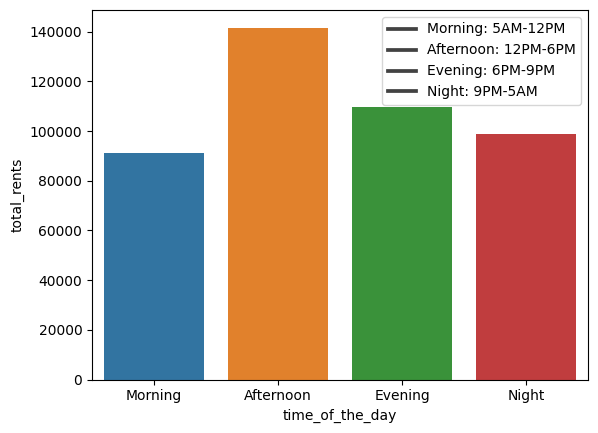

In [10]:
sn.barplot(x= pd["time_of_the_day"], y= pd['total_rents'], data=pd, order=['Morning','Afternoon','Evening','Night'])
plt.legend(['Morning: 5AM-12PM', 'Afternoon: 12PM-6PM','Evening: 6PM-9PM', 'Night: 9PM-5AM'])

In [11]:
df_hour=df.groupBy(F.hour('start_time').alias('hour')).agg(F.count('start_time').alias('total_count')).sort(F.hour('start_time'))

In [12]:
df_hour.show()

+----+-----------+
|hour|total_count|
+----+-----------+
|   0|      10025|
|   1|       6407|
|   2|       3351|
|   4|       1254|
|   5|        559|
|   6|        234|
|   7|        564|
|   8|       1927|
|   9|       8365|
|  10|      25416|
|  11|      54276|
|  12|      41677|
|  13|      20459|
|  14|      18318|
|  15|      22880|
|  16|      20242|
|  17|      18072|
|  18|      21627|
|  19|      34551|
|  20|      53646|
+----+-----------+
only showing top 20 rows



In [13]:
pd_2=df_hour.toPandas()

<Axes: xlabel='hour', ylabel='total_count'>

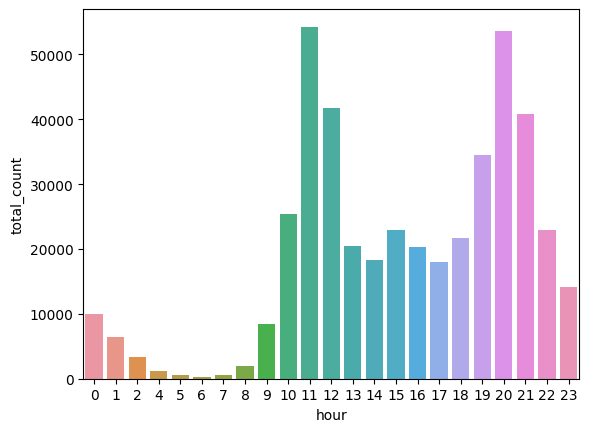

In [14]:
sn.barplot(x= pd_2["hour"], y= pd_2['total_count'], data=pd_2)

##TASK_3 - Find if there is a relation between the time and start stations

In [5]:
df.columns

['start_time',
 'start_am_pm',
 'end_time',
 'end_am_pm',
 'start_station_id',
 'start_station_name',
 'start_station_latitude',
 'start_station_longitude',
 'end_station_id',
 'end_station_name',
 'end_station_latitude',
 'end_station_longitude',
 'bike_id',
 'user_type',
 'member_birth_year',
 'member_gender',
 'pyment',
 'haversine_distance',
 'Diff_in_seconds',
 'Diff_in_minutes',
 'Trip_cost',
 'age',
 'age_group',
 'time_of_the_day']

In [15]:
df.select(['start_station_name','start_time']).groupBy(['start_station_name', F.hour('start_time').alias('hour')]).agg(F.count('start_time').alias('# of Rents')).sort(['start_station_name','hour']).show(25)


+--------------------+----+----------+
|  start_station_name|hour|# of Rents|
+--------------------+----+----------+
|10th Ave at E 15t...|   0|         2|
|10th Ave at E 15t...|   7|         1|
|10th Ave at E 15t...|   8|         2|
|10th Ave at E 15t...|   9|         4|
|10th Ave at E 15t...|  10|         4|
|10th Ave at E 15t...|  11|        23|
|10th Ave at E 15t...|  12|        16|
|10th Ave at E 15t...|  13|        20|
|10th Ave at E 15t...|  14|         9|
|10th Ave at E 15t...|  15|         9|
|10th Ave at E 15t...|  16|         8|
|10th Ave at E 15t...|  17|         1|
|10th Ave at E 15t...|  18|         8|
|10th Ave at E 15t...|  19|         7|
|10th Ave at E 15t...|  20|        11|
|10th Ave at E 15t...|  21|         3|
|10th Ave at E 15t...|  22|         7|
|10th Ave at E 15t...|  23|         4|
|10th St at Fallon St|   0|        82|
|10th St at Fallon St|   1|        28|
|10th St at Fallon St|   2|        22|
|10th St at Fallon St|   7|         1|
|10th St at Fallon St|   

In [16]:
df_station=df.select(['start_station_name','start_time']).groupBy(['start_station_name', F.hour('start_time').alias('hour')]).agg(F.count('start_time').alias('# of Rents')).sort(['start_station_name','hour'])
pd_station=df_station.toPandas()

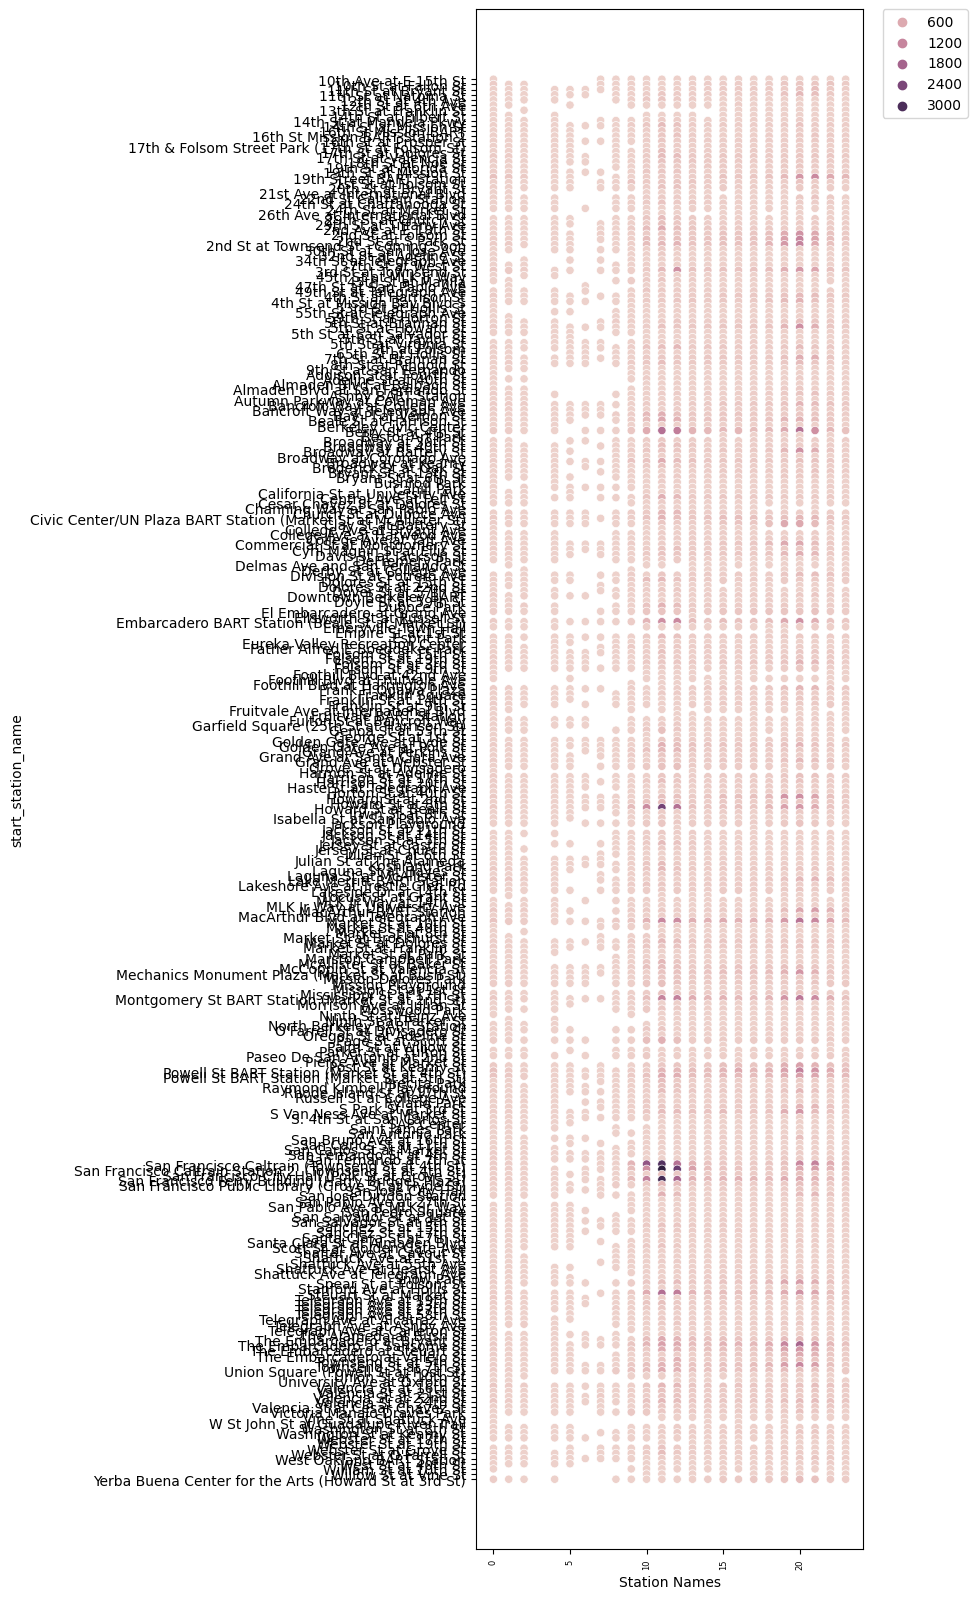

In [75]:
plt.figure(figsize=(5,20))
sn.scatterplot(x= pd_station['hour'], y= pd_station['start_station_name'], hue='# of Rents',data=pd_station)
plt.autoscale(enable=True)
plt.xlabel(xlabel='Station Names')
plt.xticks(rotation=90, fontsize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

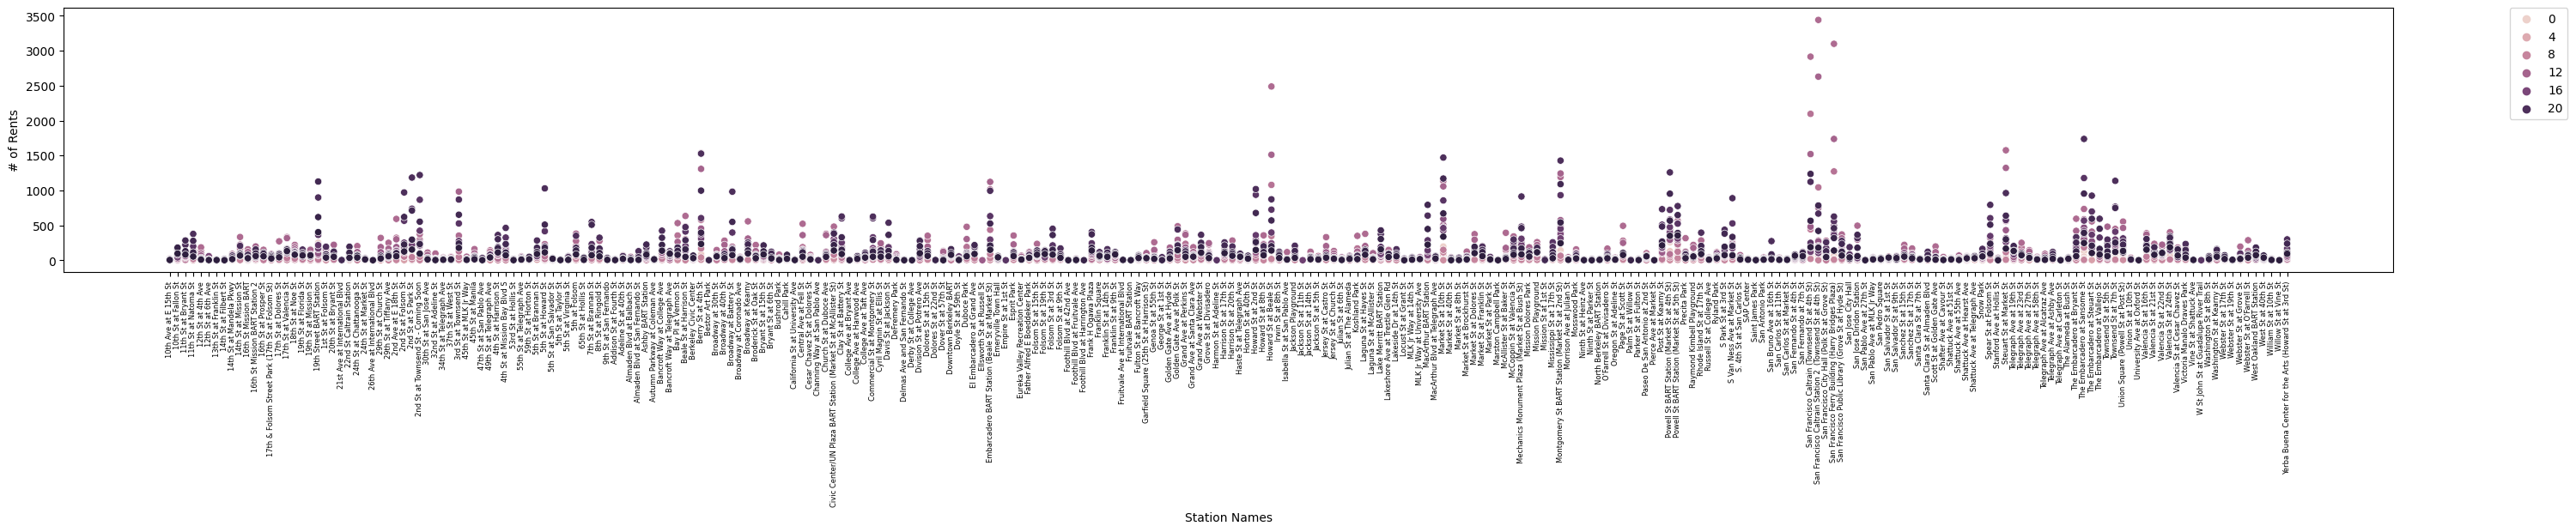

In [73]:
plt.figure(figsize=(35,4))
sn.scatterplot(x= pd_station['start_station_name'], y= pd_station['# of Rents'], hue='hour',data=pd_station)
plt.autoscale(enable=True)
plt.xlabel(xlabel='Station Names')
plt.xticks(rotation=90, fontsize=6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


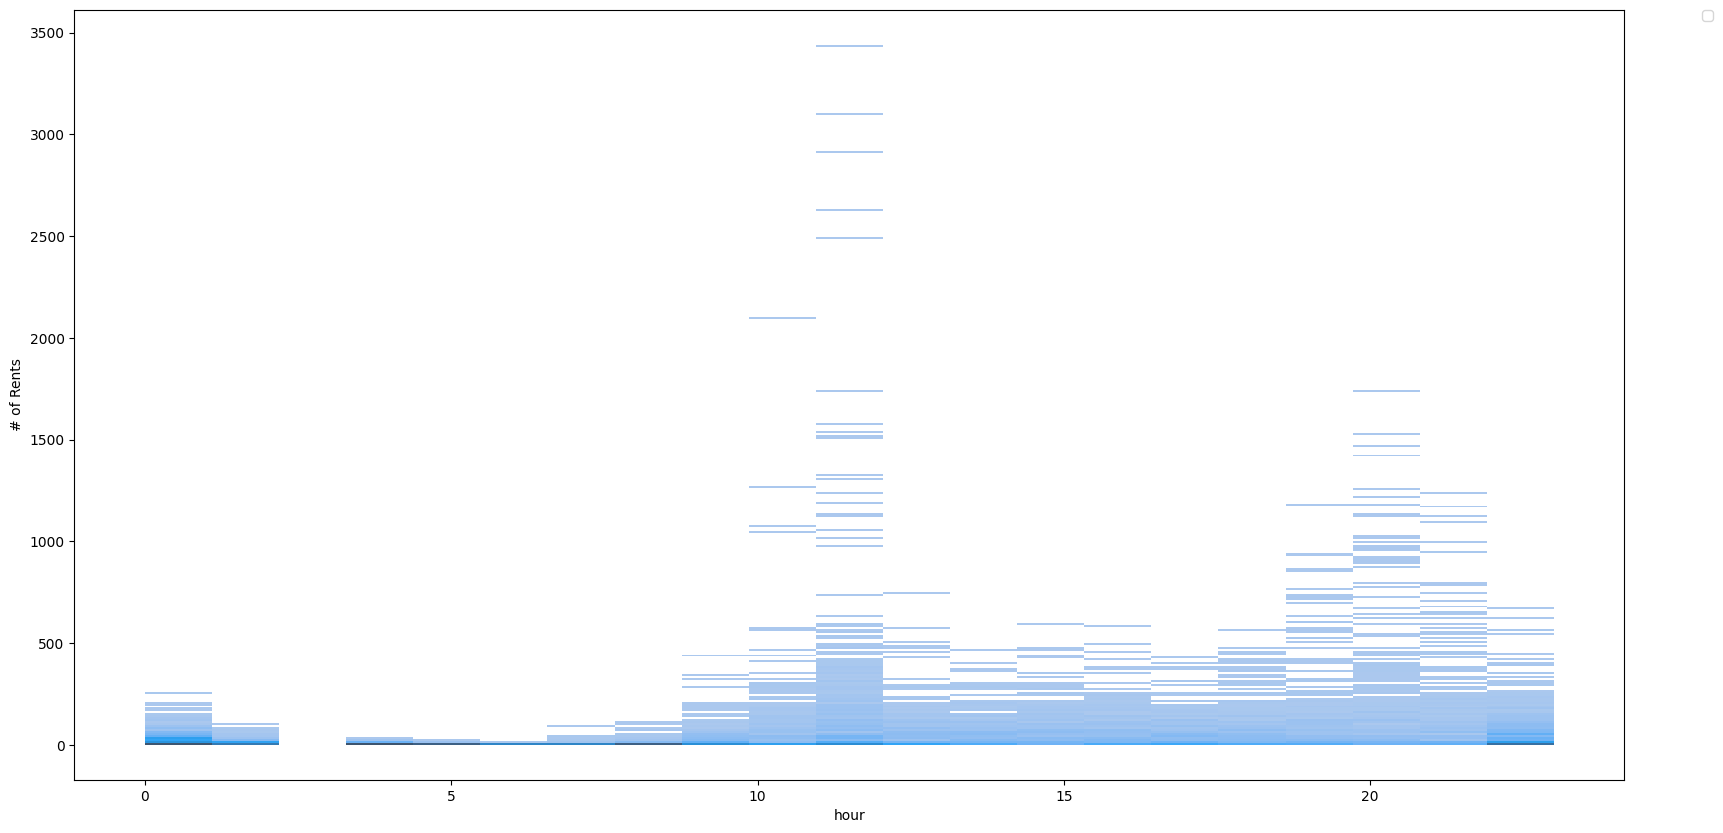

In [64]:
plt.figure(figsize=(20,10))

sn.histplot(x= pd_station["hour"], y= pd_station['# of Rents'], data=pd_station, kde=True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [46]:
sn.Plot(x= pd_station["hour"], y= pd_station['# of Rents'], hue=pd_station['start_station_name'], data=pd_station).add(sn.histplot(),sn.Dodge())

AttributeError: module 'seaborn' has no attribute 'Plot'

In [ ]:
sn.relplot(data= pd_station, kind= 'line', x='hour',y='# of Rents',hue='start_station_name')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)